In [1]:
import os
import tarfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for data visualization purposes
import seaborn as sns # for statistical data visualization
import sklearn as sk
%matplotlib inline

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)
# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)
# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

### Downloading the data

In [2]:
DATA_FOLDER = "./data"

NEWSGROUP_DATASET_URL = "http://qwone.com/~jason/20Newsgroups/20news-bydate-matlab.tgz"
gzip_file_name = NEWSGROUP_DATASET_URL.rsplit('/', 1)[1]
NEWSGROUP_FOLDER_NAME = "20news-bydate"
NEWSGROUP_FOLDER = os.path.join(DATA_FOLDER, NEWSGROUP_FOLDER_NAME)
NEWSGROUP_GZIP_PATH = os.path.join(DATA_FOLDER, gzip_file_name)
print(NEWSGROUP_GZIP_PATH)

./data/20news-bydate-matlab.tgz


In [3]:
# downloading the file
if not os.path.exists(NEWSGROUP_GZIP_PATH):
    req = requests.get(NEWSGROUP_DATASET_URL, allow_redirects=True)
    # Writing the file to the local file system
    with open(NEWSGROUP_GZIP_PATH, 'wb') as output_file:
        output_file.write(req.content)
    print("Downloaded zip file")
else:
    print("Zip file already present")

# open file
if not os.path.exists(NEWSGROUP_FOLDER):
    with tarfile.open(NEWSGROUP_GZIP_PATH) as f:
        # extracting file
        f.extractall(DATA_FOLDER)
    print("De-compressed Gzip file")
else:
    print("Un-compressed folder already present")

Downloaded zip file
De-compressed Gzip file


### Preparing Data

In [4]:
DATA_PATH = os.path.join(NEWSGROUP_FOLDER, "matlab")

TRAIN_DATA_FILE = "train.data"
TRAIN_LABEL_FILE = "train.label"
TRAIN_MAP_FILE = "train.map"

TEST_DATA_FILE = "test.data"
TEST_LABEL_FILE = "test.label"
TEST_MAP_FILE = "test.map"

train_data_path = os.path.join(DATA_PATH, TRAIN_DATA_FILE)
test_data_path = os.path.join(DATA_PATH, TEST_DATA_FILE)
train_label_path = os.path.join(DATA_PATH, TRAIN_LABEL_FILE)
test_label_path = os.path.join(DATA_PATH, TEST_LABEL_FILE)
train_map_path = os.path.join(DATA_PATH, TRAIN_MAP_FILE)
test_map_path = os.path.join(DATA_PATH, TEST_MAP_FILE)

In [5]:
def read_data_file(file_path):
    lines = None
    with open(file_path, 'r') as f:
        lines = f.read()
    lines = lines.split("\n")
    lines = [line for line in lines if line.strip()]
    return lines

def load_data(file_path):
    df = pd.read_csv(file_path, names=["doc_id", "word_id", "count"], sep=' ')
    return df

def load_labels(file_path):
    df = pd.read_csv(file_path, names=["label_id"], sep=' ')
    return df

def load_map(map_file_path):
    train_map_dict = {}
    train_map = read_data_file(map_file_path)
    for line in train_map:
        if line.strip():
            k, v = line.split()
            train_map_dict[k] = int(v)
    return train_map_dict

In [6]:
train_df = load_data(train_data_path)
train_df.dropna()
test_df = load_data(test_data_path)
test_df.dropna()

train_labels = load_labels(train_label_path)
train_labels.dropna()
test_labels = load_labels(test_label_path)
test_labels.dropna()

train_map = load_map(train_map_path)
test_map = load_map(test_map_path)
labels_to_label_ids = {**train_map, **test_map}
label_ids_to_labels = dict([(v, k) for k, v in labels_to_label_ids.items()])
del train_map
del test_map

print(train_df)
print(test_df)

         doc_id  word_id  count
0             1        1      4
1             1        2      2
2             1        3     10
3             1        4      4
4             1        5      2
...         ...      ...    ...
1467340   11269    47387      1
1467341   11269    48339      1
1467342   11269    48919      1
1467343   11269    51544      1
1467344   11269    53958      1

[1467345 rows x 3 columns]
        doc_id  word_id  count
0            1        3      1
1            1       10      1
2            1       12      8
3            1       17      1
4            1       23      8
...        ...      ...    ...
967869    7505    44515      1
967870    7505    47720      1
967871    7505    50324      1
967872    7505    59935      1
967873    7505    61188      2

[967874 rows x 3 columns]


In [7]:
train_df = pd.merge(train_df, train_labels, left_on="doc_id", right_index=True)
test_df = pd.merge(test_df, test_labels, left_on="doc_id", right_index=True)
train_df

,doc_id,word_id,count,label_id
0,1,1,4,1
1,1,2,2,1
2,1,3,10,1
3,1,4,4,1
4,1,5,2,1
...,...,...,...,...
1467128,11268,25975,2,20
1467129,11268,27356,1,20
1467130,11268,53958,1,20
1467131,11268,53974,1,20


In [8]:
# Pruning data based on word count:
# We will keep only those words which have appeared more than 1000 times in the training data.
MIN_WORD_COUNT = 1000

grouped = train_df.groupby("word_id")
grouped = grouped.agg(total_word_count=pd.NamedAgg(column="count", aggfunc="sum"))
df = grouped.reset_index()
above_1000 = df[df["total_word_count"] > MIN_WORD_COUNT]
print(above_1000["total_word_count"].describe())

# Words with more than 1000 total appearances
final_word_list = above_1000["word_id"].unique().tolist()
N_WORDS = len(final_word_list)
words_to_idx = dict([final_word_list[i], i] for i in range(len(final_word_list)))

# Prune train df
df = train_df["word_id"].isin(final_word_list)
train_df = train_df[df]
# Prune test df
df = test_df["word_id"].isin(final_word_list)
test_df = test_df[df]

# # Prune labels
# train_labels = train_labels[train_labels.index.isin(train_df.index)]
# test_labels = test_labels[test_labels.index.isin(test_df.index)]

count       292.000
mean       5213.349
std       11859.311
min        1002.000
25%        1293.250
50%        1854.500
75%        4353.000
max      144419.000
Name: total_word_count, dtype: float64


In [9]:
train_doc_ids = train_df["doc_id"].unique().tolist()
test_doc_ids = test_df["doc_id"].unique().tolist()
final_doc_id_list = train_doc_ids + test_doc_ids
final_doc_id_list.sort()

del train_doc_ids
del test_doc_ids
print(len(final_doc_id_list), final_doc_id_list[:5])

18760 [1, 1, 2, 2, 3]


In [10]:
def encode_doc_bernoulli(n_words, doc_group):
    word_counts_enc_list = np.zeros(n_words, dtype=np.int32)
    for row in doc_group.itertuples(index=False):
        word_counts_enc_list[words_to_idx[row[1]]] = 1
    return word_counts_enc_list

def encode_doc_multinomial(n_words, doc_group):
    word_counts_enc_list = np.zeros(n_words, dtype=np.int32)
    for row in doc_group.itertuples(index=False):
        word_counts_enc_list[words_to_idx[row[1]]] = row[2]
    return word_counts_enc_list
    
def encode_documents(df, group_col, n_words, enc_type="Bernoulli"):
    docs_word_count_list = []

    doc_ids = df[group_col].unique().tolist()
    doc_ids.sort()
    grouped = df.groupby(group_col)
    
    if enc_type == "Bernoulli":
        enc_fn = encode_doc_bernoulli
    elif enc_type == "Multinomial":
        enc_fn = encode_doc_multinomial
    else:
        enc_fn = encode_doc_bernoulli
    
    for doc_id in doc_ids:
        group = grouped.get_group(doc_id)
        word_counts_enc_list = enc_fn(n_words, group)
        docs_word_count_list.append(word_counts_enc_list)
    return docs_word_count_list

def get_labels_for_doc_ids(df):
    labels = []
    doc_ids = df["doc_id"].unique().tolist()
    grouped = df.groupby("doc_id")
    for doc_id in doc_ids:
        group = grouped.get_group(doc_id)
        labels.append(group.iloc[0,3])
    return labels

### a) Naive Bayes model (Tom Mitchell) using Bernoulli NB

In [11]:
# Imports for clasification
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

In [12]:
x_train = np.array(encode_documents(train_df, group_col="doc_id", n_words=N_WORDS, enc_type="Bernoulli"))
x_test = np.array(encode_documents(test_df, group_col="doc_id", n_words=N_WORDS, enc_type="Bernoulli"))
y_train = np.array(get_labels_for_doc_ids(train_df))
y_test = np.array(get_labels_for_doc_ids(test_df))

In [13]:
# Classification using Bernoulli Naive Bayes
bnb_model = BernoulliNB(binarize=False)
bnb_model.fit(x_train, y_train)
print(bnb_model)

BernoulliNB(binarize=False)


In [14]:
# Testing BernoulliNB model
y_pred = bnb_model.predict(x_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Bernoulli Naive Bayes has an accuracy of {:.2f}%".format(float(test_accuracy) * 100), "against the test set.")

Bernoulli Naive Bayes has an accuracy of 28.41% against the test set.


### b) Multinomial Naive Bayes Model

In [15]:
# Imports for clasification
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [16]:
x_train = np.array(encode_documents(train_df, group_col="doc_id", n_words=N_WORDS, enc_type="Multinomial"))
x_test = np.array(encode_documents(test_df, group_col="doc_id", n_words=N_WORDS, enc_type="Multinomial"))
y_train = np.array(get_labels_for_doc_ids(train_df))
y_test = np.array(get_labels_for_doc_ids(test_df))

In [17]:
mn_model = MultinomialNB()
mn_model.fit(x_train, y_train)
print(mn_model)

MultinomialNB()


In [18]:
# Testing Multinomial Naive Bayes
y_pred = mn_model.predict(x_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Multinomial Naive Bayes has an accuracy of {:.2f}%".format(float(test_accuracy) * 100), "against the test set.")

Multinomial Naive Bayes has an accuracy of 39.02% against the test set.


### c) TF-IDF Linear Discriminant Analysis Model

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [20]:
x_train = np.array(encode_documents(train_df, group_col="doc_id", n_words=N_WORDS, enc_type="Multinomial"))
x_test = np.array(encode_documents(test_df, group_col="doc_id", n_words=N_WORDS, enc_type="Multinomial"))
y_train = np.array(get_labels_for_doc_ids(train_df))
y_test = np.array(get_labels_for_doc_ids(test_df))

In [21]:
# TF-IDF processing:
tfidf_transformer = TfidfTransformer()
# train data processing
x_train = tfidf_transformer.fit_transform(x_train).toarray()
# test data processing
x_test = tfidf_transformer.transform(x_test).toarray()
x_train

array([[0.04079175, 0.01761314, 0.06933421, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)

LinearDiscriminantAnalysis()

In [23]:
y_pred = clf.predict(x_train)
test_accuracy = metrics.accuracy_score(y_train, y_pred)
print("LDA model accuracy: {:.2f}%".format(float(test_accuracy) * 100), " on training data.")

LDA model accuracy: 53.73%  on training data.


In [24]:
y_pred = clf.predict(x_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("LDA model accuracy: {:.2f}%".format(float(test_accuracy) * 100), " on test data.")

LDA model accuracy: 41.30%  on test data.


### d) Least Squares Model

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model

In [26]:
# Preparing train and test datasets
x_train = np.array(encode_documents(train_df, group_col="doc_id", n_words=N_WORDS, enc_type="Multinomial"))
x_test = np.array(encode_documents(test_df, group_col="doc_id", n_words=N_WORDS, enc_type="Multinomial"))
y_train = np.array(get_labels_for_doc_ids(train_df))
y_test = np.array(get_labels_for_doc_ids(test_df))

In [27]:
# TF-IDF processing:
tfidf_transformer = TfidfTransformer()
# train data processing
x_train = tfidf_transformer.fit_transform(x_train).toarray()
# test data processing
x_test = tfidf_transformer.transform(x_test).toarray()

In [28]:
# Append 1.0 to every doc vector.
one_vec = np.ones((x_train.shape[0],)).reshape(-1, 1)
x_train = np.hstack((x_train, one_vec))

one_vec = np.ones((x_test.shape[0],)).reshape(-1, 1)
x_test = np.hstack((x_test, one_vec))
print(x_train.shape, x_test.shape)

(11259, 293) (7501, 293)


In [29]:
# OneHotEncode the labels for training
all_labels = list(label_ids_to_labels.keys())
all_labels.sort()
all_labels = np.array(all_labels)

onehot_encoder = OneHotEncoder()
onehot_labels = all_labels.reshape(-1, 1)
onehot_encoder.fit(onehot_labels)
y_train = onehot_encoder.transform(y_train.reshape(-1, 1)).toarray()
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [30]:
w = np.linalg.lstsq(x_train, y_train)

/var/folders/9y/ln_z5wqj0j33qrhqjlvsvzzh0000gn/T/ipykernel_61656/3481677689.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(x_train, y_train)


In [31]:
w[0].shape

(293, 20)

In [32]:
res = np.matmul(x_test, w[0])

In [33]:
y_pred = np.array([all_labels[np.argmax(res[i])] for i in range(len(res))])
y_pred

array([ 1, 16,  1, ..., 18,  1, 16])

In [34]:
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Least Squares regressor has an accuracy of {:.2f}%".format(float(test_accuracy) * 100), "against the test set.")

Least Squares regressor has an accuracy of 41.51% against the test set.


In [35]:
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:>

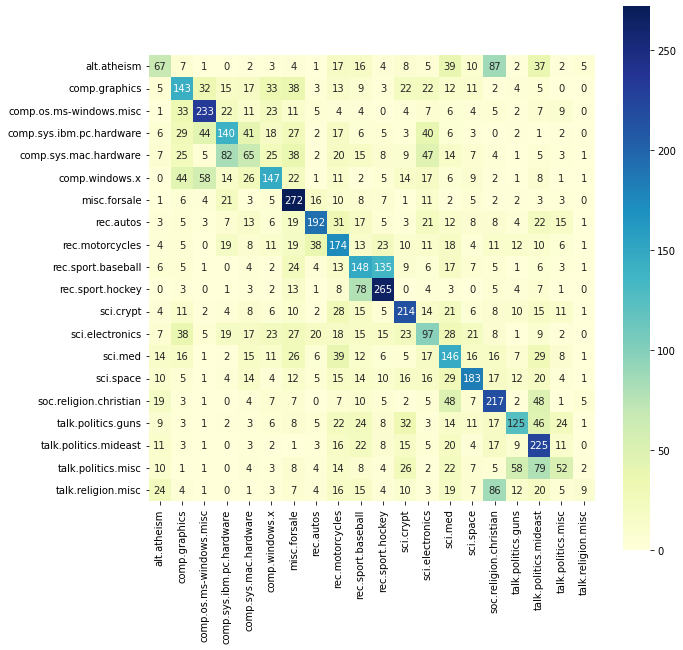

In [36]:
cm = confusion_matrix(y_test, y_pred)

label_names = [label_ids_to_labels[all_labels[i]] for i in range(len(all_labels))]

cm_matrix = pd.DataFrame(data=cm, columns=label_names, index=label_names)

plt.figure(figsize = (10, 10))
sns.heatmap(cm_matrix, annot=True, square=True, fmt='d', cmap='YlGnBu')

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.32      0.21      0.26       317
           2       0.37      0.37      0.37       389
           3       0.59      0.60      0.59       391
           4       0.40      0.36      0.38       392
           5       0.25      0.17      0.20       383
           6       0.43      0.38      0.40       389
           7       0.46      0.71      0.56       382
           8       0.61      0.49      0.54       395
           9       0.35      0.44      0.39       397
          10       0.33      0.37      0.35       397
          11       0.50      0.67      0.57       398
          12       0.50      0.54      0.52       395
          13       0.27      0.25      0.26       393
          14       0.30      0.37      0.33       393
          15       0.55      0.47      0.51       392
          16       0.42      0.55      0.47       398
          17       0.46      0.34      0.39       364
          18       0.37    